In [69]:
import os
import pandas as pd
import numpy as np
from shutil import copyfile
import time

directory = "../data/sized_images/"

In [34]:
#split up the images by postid (90% for training, 10% for validation)
#filename: index_label_postid.png
ids = []
files = []
for file in os.listdir("../data/sized_images"):
    files.append(file)
    file = file.replace(".png", "")
    file = file.split("_")
    ids.append(file[2])
posts = pd.DataFrame(list(zip(files, ids)), columns=["Files", "Ids"])

In [36]:
def split_data(df, frac=0.1):
    post_ids = df.Ids.unique()
    N = len(post_ids)
    
    test_posts = np.random.choice(post_ids, int(N * frac))
    n_test = len(test_posts)
    test_condition = df.Ids.isin(test_posts)
    return df[~test_condition], df[test_condition]

In [44]:
#do the actual splitting and sorting - only do this once!
np.random.seed(1)
train_df, test_df = split_data(posts, 0.1)
train_df, val_df = split_data(train_df, 0.1)

print(f'Training rows: {train_df.shape[0]}')
print(f'Val rows: {val_df.shape[0]}')
print(f'Test rows: {test_df.shape[0]}')

Training rows: 2398
Val rows: 319
Test rows: 283


In [54]:
start = "../data/sized_images/"
dest = "../data/CV/"
def sort(df, directory):
    for file in df.Files:
        init = start + file
        end = dest + directory + "/"
        if "biology" in file:
            end += "bio/" + file
            copyfile(init, end)
        if "chemistry" in file:
            end += "chem/" + file
            copyfile(init, end)
        if "physics" in file:
            end += "physics/" + file
            copyfile(init, end)

In [55]:
sort(train_df, "train")
sort(test_df, "test")
sort(val_df, "valid")

In [56]:
#preprocessing time
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [58]:
# define location of dataset
folder = '../data/CV/train/'
photos, labels = list(), list()
dirs = ["chem/", "physics/", "bio/"]
# enumerate files in the directory
for sub in dirs:
    subdir = folder + sub
    for file in os.listdir(subdir):
        #determine class: 0=bio, 1=physics, 2=chem
        output = 0.0
        if "physics" in file:
            output = 1.0
        if "chemistry" in file:
            output = 2.0
        #load image
        photo = load_img(subdir + file, target_size=(128, 32))
        # convert to numpy array
        photo = img_to_array(photo)
        # store
        photos.append(photo)
        labels.append(output)
# convert to numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('eqns_photos.npy', photos)
save('eqns_labels.npy', labels)

(2398, 128, 32, 3) (2398,)


time 2 learn - baseline cnn model

In [61]:
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

In [144]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    # compile model
    #opt = SGD(lr=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [133]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    #pyplot.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.show()
    pyplot.close()

In [150]:
# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow_from_directory('../data/CV/train/',
        class_mode='sparse', batch_size=20, target_size=(128, 32))
    test_it = datagen.flow_from_directory('../data/CV/test/',
        class_mode='sparse', batch_size=20, target_size=(128, 32))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    _, acc = model.evaluate_generator(train_it, steps=len(train_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

Found 2398 images belonging to 3 classes.
Found 283 images belonging to 3 classes.
> 46.539


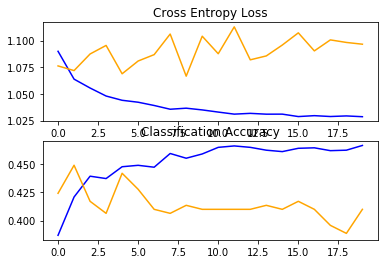

3.9720573981602985


In [151]:
start = time.time()
run_test_harness()
end = time.time()
print((end-start)/60.0)

In [152]:
#try a pre-compiled model (VGG16)
from keras.applications.vgg16 import VGG16

In [153]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 32, 3)) #pooling?

58892288/58889256 [==============================] - 3s 0us/step


Found 2398 images belonging to 3 classes.
Found 283 images belonging to 3 classes.
> 43.463


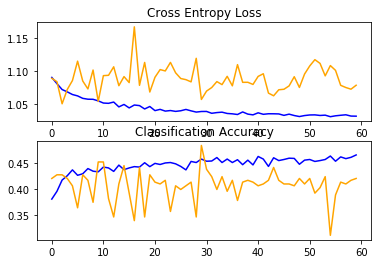

12.94573010603587


In [126]:
start = time.time()

# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare iterators
train_it = datagen.flow_from_directory('../data/CV/train/',
    class_mode='sparse', batch_size=20, target_size=(128, 32))
test_it = datagen.flow_from_directory('../data/CV/test/',
    class_mode='sparse', batch_size=20, target_size=(128, 32))
# fit model
history = base_model.fit_generator(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
# evaluate model
_, acc = base_model.evaluate_generator(train_it, steps=len(train_it), verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history)

end = time.time()
print((end-start)/60.0)